In [ ]:
!pip install statsmodels

In [ ]:
!pip install gluonts mxnet

In [ ]:
import gluonts
print(gluonts.__version__)

0.14.4


In [ ]:
!pip install numpy==1.23

100%|██████████| 50/50 [00:03<00:00, 14.87it/s, epoch=10/10, avg_epoch_loss=3.66]


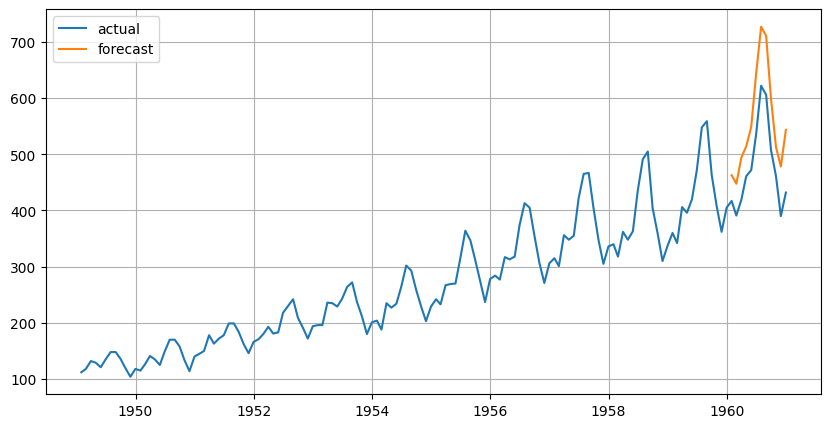

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator  # 确保正确的导入路径

# 步骤 1: 数据加载和预处理
data = get_rdataset("AirPassengers", "datasets").data
data.index = pd.date_range(start="1949-01", periods=len(data), freq='M')
data = data['value'].astype(float)

# 创建训练数据集
training_data = ListDataset(
    [{"start": data.index[0], "target": data[:-36]}],
    freq="M"
)

# 步骤 2: 定义DeepAR模型
estimator = DeepAREstimator(
    freq="M",
    prediction_length=12,
    trainer=Trainer(epochs=10)
)

# 步骤 3: 模型训练和预测
predictor = estimator.train(training_data=training_data)

# 生成预测
test_data = ListDataset(
    [{"start": data.index[0], "target": data}],
    freq="M"
)

# 进行预测并绘图
for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, label='actual')
    forecast_entry = forecast.quantile(0.5)
    forecast_dates = pd.date_range(start=data.index[-12], periods=12, freq='M')
    plt.plot(forecast_dates, forecast_entry, label='forecast')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/50
114/114 [==============================] - 2s 3ms/step - loss: 0.0183
Epoch 2/50
114/114 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 3/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 4/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 5/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 6/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 7/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 8/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9/50
114/114 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 10/50
114/114 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 11/50
114/114 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 12/50
114/114 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 13/50
114/114 [====

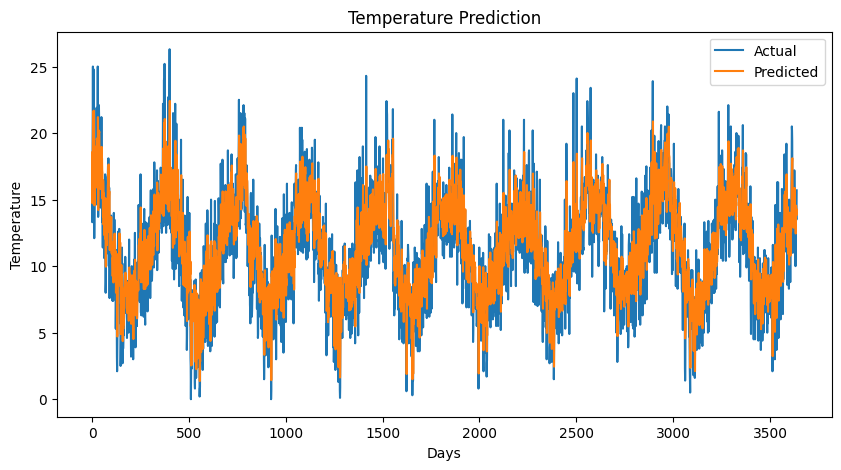

In [ ]:
#卷积神经网络
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 步骤 1: 数据加载和预处理
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
temperature = df['Temp'].values
temperature = temperature.reshape(-1, 1)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
temperature = scaler.fit_transform(temperature)

# 创建数据窗口
def create_dataset(data, look_back=10):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(temperature, look_back)

# 重塑输入数据为 [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# 步骤 2: 构建 CNN 模型
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 步骤 3: 模型训练
model.fit(X, Y, epochs=50, batch_size=32, verbose=1)

# 预测并计算误差
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(Y.reshape(-1, 1))
mse = mean_squared_error(actual, predictions)
print("MSE:", mse)

# 步骤 4: 结果可视化
plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Temperature Prediction')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()